### TODOs
 - [ ] **Experiment1:** Normalize data in `Pre-processing` section.
 - [ ] **Refactor:** Generalize train and evalutation functions.
 - [ ] Create a function to inference a single image that returns the predicted class and its score.
 - [ ] **Experiment3:** Try to initialize AlexNet with weights from hand shape prediciton or something similar.
 - [ ] **Refactor**: MNIST notebook is applying 2 times softmax
 - [ ] **Refactor**: check all :) 
 

# Summary

- [WIP] Experiment 1. Transfer learning, AlexNet with pre-trained weights

        ERROR: The training loss performs weird, increasing over the steps and with very high values

- [WIP] Experiment 2. Custom CNN

        Not implemented.

# Image Classification with Sign Language MNIST dataset

## Prepare environment

In [ ]:
# Install dependencies
! pip install torch torchvision pandas matplotlib scipy pillow

In [1]:
# Import modules
import random

from copy import deepcopy
from pathlib import Path
from math import floor

import torch

from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torch.utils.data.dataset import Dataset

from torch import nn
from torch.nn import functional as F
from torch import optim

from torchvision import models
from torchvision import transforms

import numpy as np
import pandas as pd
from scipy import ndimage

from matplotlib import pyplot as plt

from PIL import Image

## Global parameters

In [2]:
VERBOSE = False

## Load data

In [3]:
# Dataset path
dataset_path = Path('datasets/sign-language-mnist')
train_csv_path = dataset_path.joinpath('sign_mnist_train.csv')
test_csv_path = dataset_path.joinpath('sign_mnist_test.csv')

# Load CSV data as dataframes
train_df = pd.read_csv(str(train_csv_path))
test_df = pd.read_csv(str(test_csv_path))

# Get labels
train_labels = train_df['label'].values
test_labels = test_df['label'].values

# Drop labels from dataframes
train_df.drop('label', axis = 1, inplace = True)
test_df.drop('label', axis = 1, inplace = True)

# Resahpe images to 1x28x28 (Channels x Width x Height) into a numpy array
train_images = np.array([i.reshape(1, 28, 28) for i in (train_df.values.astype(np.uint8))])
test_images = np.array([i.reshape(1, 28, 28) for i in (test_df.values.astype(np.uint8))])

# Convert numpy to Tensor
train_images_tensor = torch.FloatTensor(train_images)
train_labels_tensor = torch.LongTensor(train_labels)
test_images_tensor = torch.FloatTensor(test_images)
test_labels_tensor = torch.LongTensor(test_labels)

if VERBOSE:
    print(f'train_df dataframe summary:\n {train_df.head(2)}\n')
    print(f'test_df dataframe summary:\n {test_df.head(2)}\n')

    print(f'train_labels type is {type(train_labels)}\n')
    print(f'test_labels type is {type(test_labels)}\n')

    print(f'train_df dataframe summary:\n {train_df.head(2)}\n')
    print(f'train_df dataframe summary:\n {test_df.head(2)}\n')

    print(f'train_images type is {type(train_images)} with shape {train_images.shape}\n')
    print(f'test_images type is {type(test_images)} with shape {test_images.shape}\n')

    print(f'train_images_tensor type is {type(train_images_tensor)} with shape {train_images_tensor.shape}\n')
    print(f'train_labels_tensor type is {type(train_labels_tensor)} with shape {train_labels_tensor.shape}\n')
    print(f'test_images_tensor type is {type(test_images_tensor)} with shape {test_images_tensor.shape}\n')
    print(f'test_labels_tensor type is {type(test_labels_tensor)} with shape {test_labels_tensor.shape}\n')

## Show original images

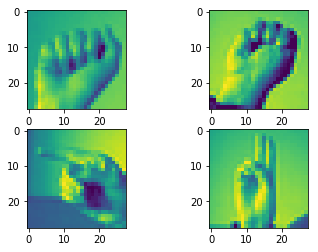

In [4]:
plt.subplot(221)
plt.imshow(train_images_tensor[50,0,:,:])
plt.subplot(222)
plt.imshow(train_images_tensor[100,0,:,:])
plt.subplot(223)
plt.imshow(test_images_tensor[25,0,:,:])
plt.subplot(224)
plt.imshow(test_images_tensor[75,0,:,:])

# Experiment 1. Transfer learning, AlexNet with pre-trained weights

## Resize images to be compatible with AlexNet

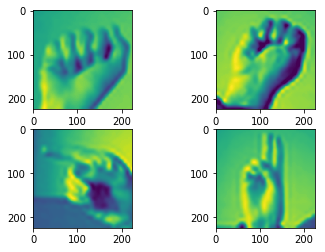

In [10]:
# The given image size (28, 28) is not compatible with AlexNet because AlexNet's input size is (224, 224).
# CAVEAT! Not using all available images because of jupyter kernel failure

E1_zoom_factor = 224/28
E1_train_samples = 500
E1_test_samples = 100
E1_train_images_tensor = torch.FloatTensor(ndimage.zoom(train_images[0:E1_train_samples], 
                                                         (1, 1, E1_zoom_factor, E1_zoom_factor)))
E1_test_images_tensor = torch.FloatTensor(ndimage.zoom(test_images[0:E1_test_samples], 
                                                        (1, 1, E1_zoom_factor, E1_zoom_factor)))

# Show resized images for AlexNet compatibility
plt.subplot(221)
plt.imshow(E1_train_images_tensor[50,0,:,:])
plt.subplot(222)
plt.imshow(E1_train_images_tensor[100,0,:,:])
plt.subplot(223)
plt.imshow(E1_test_images_tensor[25,0,:,:])
plt.subplot(224)
plt.imshow(E1_test_images_tensor[75,0,:,:])

## Preprocessing

In [ ]:
# Normalize data according with the documentation (https://pytorch.org/docs/stable/torchvision/models.html)
# ...

## Generate PyTorch Datasets

In [ ]:
E1_train_set = TensorDataset(E1_train_images_tensor, train_labels_tensor[0:E1_train_samples])
E1_test_set = TensorDataset(E1_test_images_tensor, test_labels_tensor[0:E1_test_samples])

# Split train set into train and validation subsets
E1_num_examples = len(E1_train_set)
E1_num_validation_examples = floor(0.3*len(E1_train_set))
E1_num_train_examples = len(E1_train_set) - E1_num_validation_examples
print(f'Number of examples: {E1_num_examples} \n'
      f'Number of train examples: {E1_num_train_examples} \n'
      f'Number of validation examples: {E1_num_validation_examples}')

E1_subsets = random_split(E1_train_set, [E1_num_train_examples, E1_num_validation_examples])
E1_train_subset = E1_subsets[0]
E1_validation_subset = E1_subsets[1]

# Dataloaders
E1_train_loader = DataLoader(E1_train_subset, batch_size=32, shuffle=True)
E1_validation_loader = DataLoader(E1_validation_subset, batch_size=32, shuffle=True)
E1_test_loader = DataLoader(E1_test_set, batch_size=32, shuffle=True)

## Load AlexNet with pre-trained weights

In [ ]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        # Load pre-trained AlexNet
        self.original_alexnet = models.alexnet(pretrained=True)
        self.alexnet = deepcopy(self.original_alexnet)
        
        # Freeze conv weights
        # for weight in self.alexnet.features.parameters():
        #     weight.requires_grad = False
        
        # Adapt first and last layers to the dataset
        self.alexnet.features[0] = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(11, 11), 
                                             stride=(4, 4), padding=(2, 2))
        # the dataset does not have any sample of the 'j' (9) and 'z' (25) letters, but I add them to the classifier
        missing_letters = 2
        self.alexnet.classifier[-1] = nn.Linear(4096, len(train_labels_tensor.unique()) + missing_letters)
        
    def forward(self, x):
        x = self.alexnet(x)
        return F.log_softmax(x, dim=1)
        
    def show_model_changes(self):
        print(f'Original AlexNet:\n{self.original_alexnet}')
        print(f'Modified AlexNet:\n{self.alexnet}')
        
alexnet = AlexNet()
alexnet.show_model_changes()

## Train and evaluate AlexNet

In [ ]:
# Train model
E1_criteria = nn.CrossEntropyLoss()
E1_optimizer = optim.RMSprop(alexnet.parameters())

# For each epoch...
for epoch in range(5):
    # Training part
    alexnet.train()
    # For each mini-batch
    for batch_idx, (data, target) in enumerate(E1_train_loader):
        # Forward
        output = alexnet(data)
        # Calculate loss
        loss = E1_criteria(output, target)
        # Clear previous gradients (make gradients zero)
        E1_optimizer.zero_grad()
        # Backpropagation
        loss.backward()
        # Update model parameters
        E1_optimizer.step()
        
        print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(E1_train_loader.dataset)}'
              f'({round(100. * batch_idx / len(E1_train_loader), 2)}%)]\t'
              f'Loss: {round(loss.item(), 6)}')
    
    # Evaluation part-> Validation set
    alexnet.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in E1_validation_loader:
            output = alexnet(data)
            validation_loss += E1_criteria(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(E1_validation_loader.dataset)
    print('\n'
          f'Validation set: Average loss: {round(validation_loss, 6)}, '
          f'Accuracy: {correct}/{len(E1_validation_loader.dataset)} '
          f'({round(100. * correct / len(E1_validation_loader.dataset), 3)}%)\n')  

# Experiment 2. Custom CNN

## Preprocessing

## Generate PyTorch Datasets

In [ ]:
E2_train_set = TensorDataset(train_images_tensor, train_labels_tensor)
E2_test_set = TensorDataset(test_images_tensor, test_labels_tensor)

# Split train set into train and validation subsets
E2_num_examples = len(E2_train_set)
E2_num_validation_examples = floor(0.3*len(E2_train_set))
E2_num_train_examples = len(E2_train_set) - E2_num_validation_examples
print(f'Number of examples: {E2_num_examples} \n'
      f'Number of train examples: {E2_num_train_examples} \n'
      f'Number of validation examples: {E2_num_validation_examples}')

E2_subsets = random_split(E2_train_set, [E2_num_train_examples, E2_num_validation_examples])
E2_train_subset = E2_subsets[0]
E2_validation_subset = E2_subsets[1]

# Dataloaders
E2_train_loader = DataLoader(E2_train_subset, batch_size=32, shuffle=True)
E2_validation_loader = DataLoader(E2_validation_subset, batch_size=32, shuffle=True)
E2_test_loader = DataLoader(E2_test_set, batch_size=32, shuffle=True)

## Create BasicCNN

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3))
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(2, 2))
        self.fc1 = nn.Linear(64*12*12, 32)
        self.fc2 = nn.Linear(32, 26)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), kernel_size=(2, 2)))
        # cnn output size = (input_size - kernel_size + 2*padding)/stride + 1
        # feature map size = [ (28-3+2*0)/(1) + 1 = 26 ] / 2 = 13
        x = F.relu(self.conv2(x))
        # feature map size = (13-2)/1 + 1 = 12
        x = x.view(-1, 64*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)
    
basic_cnn = BasicCNN()
print(basic_cnn)

## Train and evaluate BasicCNN

In [ ]:
# Train model
criteria = nn.NLLLoss()
optimizer = optim.Adam(basic_cnn.parameters())

# For each epoch...
for epoch in range(5):
    # Training part
    basic_cnn.train()
    # For each mini-batch
    for batch_idx, (data, target) in enumerate(E2_train_loader):
        # Clear previous gradients (make gradients zero)
        optimizer.zero_grad()
        # Forward
        output = basic_cnn(data)
        # Calculate loss
        loss = criteria(output, target)
        # Backpropagation
        loss.backward()
        # Update model parameters
        optimizer.step()
        
        print(f'Epoch: {epoch} [{batch_idx * len(data)}/{len(E2_train_loader.dataset)}'
              f'({round(100. * batch_idx / len(E2_train_loader), 2)}%)]\t'
              f'Loss: {round(loss.item(), 6)}')
    
    # Evaluation part-> Validation set
    basic_cnn.eval()
    validation_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in E2_validation_loader:
            output = basic_cnn(data)
            validation_loss += criteria(output, target).item() # sum up batch loss
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    validation_loss /= len(E2_validation_loader.dataset)
    print('\n'
          f'Validation set: Average loss: {round(validation_loss, 6)}, '
          f'Accuracy: {correct}/{len(E2_validation_loader.dataset)} '
          f'({round(100. * correct / len(E2_validation_loader.dataset), 3)}%)\n')  